# Accessing the control run 

Here's a demonstration on how to read and visualize data from MET Norways thredds-server

You can navigate to the control run by going to this web adress: 
http://thredds.met.no/thredds/catalog/metusers/arildb/catalog.html

If you click on the file MARTINI800_prov_v2.ncml, there's a list of several ways to access the data. 
This demonstration is based on the first option, OPENDAP. Clicking on the OPENDAP link opens a new page, and the URL to use from python (or R) is listed near the top. Also, all variables on in the provisional hindcast is listed, with information about their dimensions, and attributes describing each variable. 

For example, there is a variable called P1_Chl which has dimension time, vertical coordinate, y, and x. 
The long_name assigned to this variable tells us that it represent diatoms/chlorophyll a, and it has units mg/m^3
The horizontal grid corresponds to the positions in the variables lon_rho and lat_rho.



### importing packages and open file for reading

In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean

import roppy # This is Bjørn Ådlandsvik's (IMR) python package for ROMS grid metrics
# I will use roppy to get the thickness of the vertical grid cells below

filepath = 'http://thredds.met.no/thredds/dodsC/metusers/arildb/MARTINI800_prov_v2.ncml' # The OPENDAP URL

filehandle = Dataset(filepath) # open for reading 
grid = roppy.SGrid(filehandle)


### Reading a netCDF file in python
The python package used to read the dataset is described in detail here: https://unidata.github.io/netcdf4-python/netCDF4/index.html

In short, once you have opened a file/URL for reading you can access all variables on the file through:

    variable = filehandle.variables['variablename']

Now you can find which dimensions this variable has by e.g.:

    print(variable.dimensions)

You can also access all the dimensions on the file by:

    dimension = filehandle.dimensions['dimensionname']

or find the size of a dimension by 

    dimensionsize = len(filehandle.dimensions['dimensionname'])  



In [2]:
# Access to the longitude, latitude coordinates
lon = filehandle.variables['lon_rho']
lat = filehandle.variables['lat_rho']

# Access to the chlorophyll A variable
chla = filehandle.variables['P1_Chl']

# Let's see what the dimensions of this variable is by looping over the dimensions
for dimension in chla.dimensions:
    # We'll print both dimension name, and the size of th dimension
    print('{}: {}'.format( dimension,  len(filehandle.dimensions[dimension] ) ) )

print('\n') # Ensure a blank line between chla and longitude dimensions

# And lets look at longitude as well:
for dimension in lon.dimensions:
    # We'll print both dimension name, and the size of th dimension
    print( '{}: {}'.format( dimension,  len( filehandle.dimensions[dimension] ) ) )

ocean_time: 364
s_rho: 42
eta_rho: 426
xi_rho: 480


eta_rho: 426
xi_rho: 480


Let's say we're interested in the time evaluation of the Chlorophyll A concentration in the whole water column at the ØKOKYST station Torbjørnskjær.

In [3]:
# The decimal degree location of the Torbjørnskjær station:
torbjornskjar_lon = 10.6653
torbjornskjar_lat = 59.0361

# We need to find the grid location closest to Torbjørnskjær.
# For the sake of simplicity, let's calculate the sum of the absolute 
# differences between all grid points latitude and longitude and the 
# Torbjørnskjær coordinates. 

position_diff = np.abs( lat[:] - torbjornskjar_lat ) + np.abs( lon[:] - torbjornskjar_lon )

# This line will find the indices of the minimum value in 
i, j = np.unravel_index( position_diff.argmin(), position_diff.shape )

print('Grid indices of grid point closest to Torbjørnskjær: {}, {}\n'.format(i, j))
print('Grid point longitude: {}'.format(lon[i,j]))
print('Grid point latitude: {}'.format(lat[i,j]))


Grid indices of grid point closest to Torbjørnskjær: 201, 367

Grid point longitude: 10.668787924052388
Grid point latitude: 59.03713575538488


### Dealing with the vertical grid in the ROMS file
Since the variable has units mg/m3 and the vertical grid is not regular, we will need to know the thickness of each vertical grid cell, as well as the horizontal area to convert to mg. 

The horizontal area is easy, the data is on a grid with 800*800 meters resolution.

The roppy grid object we created above has a variable called z_w, which holds the lower depth level of each cell (as well as the surface value). 
Since ROMS uses a terrain-following vertical coordinate, these depths vary not only in the vertical but in the horizontal as well.




In [4]:
dZ = grid.z_w[1:, i,j] - grid.z_w[:-1, i, j]  # The thickness of the vertical grid cells on Torbørnskjær

### Dealing with time in python

In [5]:
# Get time variable from file 
ocean_time = filehandle.variables['ocean_time']
# The time on a netCDF file is usually specified as seconds/days/hours since a reference date
# This should be specified in the units attribute:
print('Units of ocean_time: {}\n'.format(ocean_time.units))

# The python package datetime is convinient for handling conversion from the numbers in ocean_time
# to actual dates, and back again.

expected_format = 'seconds since %Y-%m-%d %H:%M:%S'
timeref = datetime.strptime(ocean_time.units, expected_format) # Creating a datetime object for the reference time

ocean_time = filehandle.variables['ocean_time'][:]
# Let's see what first and last timestamp on the file is:
print('First timestamp on file: {}'.format( timeref + timedelta(seconds = ocean_time[0] ) ))
print('Second timestamp on file: {}'.format( timeref + timedelta(seconds = ocean_time[1] ) ))
print('Third timestamp on file: {}'.format( timeref + timedelta(seconds = ocean_time[2] ) ))
print('Second to last timestamp on file: {}'.format( timeref + timedelta(seconds = ocean_time[-2] )) )
print('Last timestamp on file: {}'.format( timeref + timedelta(seconds = ocean_time[-1] ) ))

# make new time variable that contains datetime objects:
dates = np.array([ timeref + timedelta(seconds=t) for t in ocean_time  ])

Units of ocean_time: seconds since 1970-01-01 00:00:00

First timestamp on file: 2017-01-02 00:00:00
Second timestamp on file: 2017-01-03 00:00:00
Third timestamp on file: 2017-01-04 00:00:00
Second to last timestamp on file: 2017-12-30 00:00:00
Last timestamp on file: 2017-12-31 00:00:00


## Plotting a time series

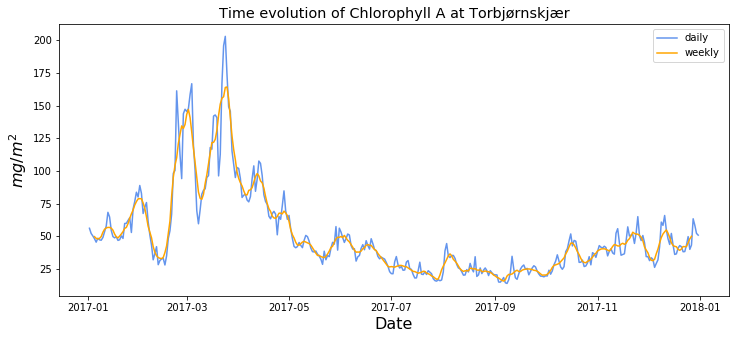

In [6]:
# To get the concentration in the whole water column,  
# we calculate the sum of all vertical grid cells 
# the axis = 1 argument in the function call below means we sum over the z-axis  
# Remember, the dimensions are in (t,z,y,x) order and as indexing in Python starts from zero, 
# axis = 1 points to the z-dimension. 

chla_at_torbjornskjar = np.sum( chla[:,:,i,j] * dZ, axis = 1)  # Leaves us with a timeseries with unit mg/m2 

# A simple plot of the timeseries:
plt.figure(figsize=(12,5))
plt.plot(dates, chla_at_torbjornskjar, color = 'cornflowerblue', label = 'daily') # our dates array is used as x-axis

# Add axis labels. 
plt.ylabel('$mg/m^2$', fontsize = 16);  
plt.xlabel('Date', fontsize = 16);


# We can also make a smoother timeseries, with e.g. weekly means

# Make a running weekly average (we saw abobe that the file holds daily values)
mean_chla = np.array([ np.mean(chla_at_torbjornskjar[n:n+7]) for n in range(len(chla_at_torbjornskjar) -7) ])

# Calculate the mean of the timestamps in a similar manner
mean_time =  np.array([ np.mean(ocean_time[n:n+7]) for n in range(len(chla_at_torbjornskjar) -7) ]) # this is in seconds since reftime
mean_time = np.array([ timeref + timedelta(seconds=t) for t in mean_time ]) # this is datetime objects



plt.plot(mean_time, mean_chla, color = 'orange', label = 'weekly')

plt.legend(loc='upper right');
plt.title('Time evolution of Chlorophyll A at Torbjørnskjær', fontsize = 'x-large');



Now I would like to plot the Chlorophyll A concentration in the whole MARTINI domain, 
at the time when the concentration reaches its maximum at Torbjørnskjær. 

Thus, I will need to know the thickness of all grid cells, not just in one grid point. 


In [7]:
grid_dZ = grid.z_w[1:, :,:] - grid.z_w[:-1, :, :]  # The thickness of the vertical grid cells on Torbørnskjær

maxIndex = np.argmax(mean_chla) # gets the index of the maximum-value


# This time, we have taken away the first dimension (time) by picking only one timestamp.
# Thus, z is the first dimension of the variable we want to calculate the sums for. 

max_chla = np.sum(chla[np.argwhere(dates == mean_time[maxIndex])[0],:,:,: ].squeeze() * grid_dZ, axis=0)

# Printing the shape of max_chla to make sure it has the right dimensions:
print('Shape of max_chla: {}'.format(max_chla.shape))

# And let's repeat the dimensions of the horizontal grid
for dimension in lon.dimensions:
    # We'll print both dimension name, and the size of th dimension
    print( '{}: {}'.format( dimension,  len( filehandle.dimensions[dimension] ) ) )

Shape of max_chla: (426, 480)
eta_rho: 426
xi_rho: 480


### Cartopy - for plotting data on a map
Visualizing data on a map is slightly more complicated. 
For this purpose, I use the python package cartopy (https://scitools.org.uk/cartopy/docs/latest/)

The simplest map we can make with Cartopy is based on a projection called Plate Carrée

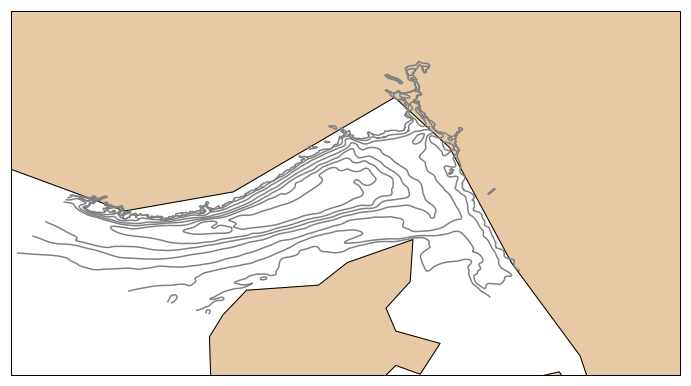

In [8]:
simple_map  = ccrs.PlateCarree(central_longitude=0.0, globe=None) # Set the map projection
 

fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(projection=simple_map),  figsize=(12, 9))

# Use model domain values as map boundaries 
# crs = ccrs.PlateCarree() means that values provided are in longitude, latitude format, not grid coordinates
# associated with some other map projection.

ax.set_extent([np.min(lon), np.max(lon),np.min(lat), np.max(lat)],crs = ccrs.PlateCarree()) 

ax.add_feature(cfeature.LAND, facecolor='burlywood', alpha=0.75);  # Adding land
ax.add_feature(cfeature.COASTLINE); # Adding coastline
ax.add_feature(cfeature.RIVERS);  # Drawing rivers.

im = ax.contour(lon[:], lat[:], grid.h, levels = [25, 50, 100, 200, 300, 400, 500],  transform = ccrs.PlateCarree(), colors = 'gray')
#plt.colorbar(im, ax=ax)

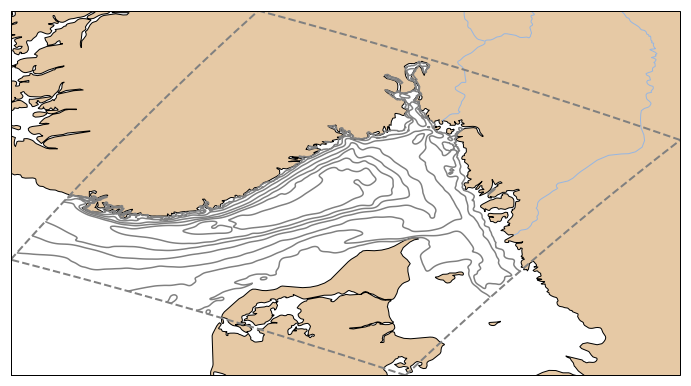

In [9]:
# The coarse resolution is not suitable for our domain
#  Now, instead of the default land, coastlines and rivers, we will use higher resolution data

river_10m = cfeature.NaturalEarthFeature(
    category = 'physical', name = 'rivers_lake_centerlines',
    scale = '10m', facecolor = 'none', edgecolor = cfeature.COLORS['water'])

land_10m = cfeature.NaturalEarthFeature(
    category = 'physical', name = 'land',
    scale = '10m', edgecolor = 'none',facecolor = cfeature.COLORS['land'])

coastline_10m = cfeature.NaturalEarthFeature(
    category = 'physical', name = 'coastline',
    scale = '10m', edgecolor = 'k',facecolor = 'none')


fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(projection=simple_map),  figsize=(12, 9))

# Use model domain values as map boundaries 
# crs = ccrs.PlateCarree() means that values provided are in longitude, latitude format, not grid coordinates
# associated with some other map projection.

ax.set_extent([np.min(lon), np.max(lon),np.min(lat), np.max(lat)],crs = ccrs.PlateCarree()) 

ax.add_feature(land_10m, facecolor='burlywood', alpha=0.75)  # Adding land
ax.add_feature(coastline_10m) # Adding coastline
ax.add_feature(river_10m) # Drawing rivers.

# Plotting the map boundaries:
ax.plot(lon[0,:], lat[0,:], '--', transform= ccrs.PlateCarree(), color = 'gray', linewidth =2)
ax.plot(lon[-1,:], lat[-1,:], '--', transform= ccrs.PlateCarree(), color = 'gray', linewidth =2)  
ax.plot(lon[:,0], lat[:,0], '--', transform= ccrs.PlateCarree(), color = 'gray', linewidth =2)
ax.plot(lon[:,-1], lat[:,-1], '--', transform= ccrs.PlateCarree(), color = 'gray', linewidth =2)


ax.contour(lon[:], lat[:], grid.h, levels = [25, 50, 100, 200, 300, 400, 500],  transform = ccrs.PlateCarree(), colors = 'gray')


The Martini model domain has a projection described in the grid_mapping variable on the grid file.
The information we need to make a plot of only the Martini domain is in the proj4string attribute:

proj4string = "+proj=stere +ellps=WGS84 +lat_0=90.0 +lat_ts=60.0 +lon_0=70 +x_0=3192800 +y_0=1784000"



In [10]:
# First we need to define a stereographic map projection. 
# central latitude and logitude correspond to lat_0 and lat_0 in the projstring
# true_scale_latitude is the lat_ts value in the string
crs = ccrs.Stereographic(central_latitude=90, central_longitude=70, true_scale_latitude=60,false_easting=0, false_northing=0)

# We can find the x,y coordinates of the projection by the transform_points function.
# The ccrs.PlateCarree() argument is there to tell the function that the lon,lat values are lon,lat
# (They could by x,y coordinates of a different map projection)
transform = crs.transform_points(ccrs.PlateCarree(), lon[:], lat[:])
x = transform[..., 0]
y = transform[..., 1]
 

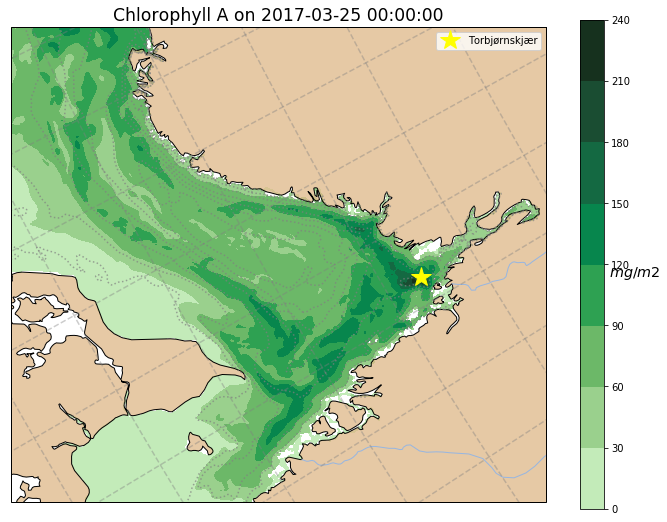

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(projection=crs),  figsize=(12, 9))

# This is the way to set exact map boundaries for stereographic projections. 
# From all the lat, lon values of the grid - calculate x,y projection coordinates. 
# Use their minimum and maximum values to set boundaries, and specify that values 
# are in the chosen projection. 

ax.set_extent( [x.min(), x.max(), y.min(), y.max()] , crs = crs)
ax.gridlines(linewidth = 1.5,color = 'gray', alpha = 0.4, linestyle = '--')


ax.add_feature( land_10m, facecolor = 'burlywood', alpha = 0.75 )
ax.add_feature(coastline_10m) # Adding coastline
ax.add_feature(river_10m) # Drawing rivers.

# Plot the chlorophyll data on the map 
# (note that I use lon,lat and tell the function that the coordinates need to be transformed )
im = ax.contourf(lon[:], lat[:], max_chla, transform = ccrs.PlateCarree(), cmap = cmocean.cm.algae)
cbar = plt.colorbar(im,  ax= ax,orientation = 'vertical') # Add colorbar
cbar.set_label('$mg/m2$', rotation=0, fontsize = 'x-large') # label the colorbar

# Put a star at the location of Torbjørnskjær:
ax.plot(torbjornskjar_lon, torbjornskjar_lat, linestyle = 'none', transform = ccrs.PlateCarree(), color = 'yellow', marker ='*', markersize=20 , label = 'Torbjørnskjær')

# We can also plot data on the map using the x, y coordinates we calculated with the transform_point function. 
# Note that this function call does not have a transform argument: x,y are already in the correct projection. 
ax.contour(x, y, grid.h, levels = [25, 50, 100, 200, 300, 400, 500], colors = 'gray', alpha = 0.7, linestyles = 'dotted')


plt.legend(loc = 'upper right');
plt.title('Chlorophyll A on {}'.format(mean_time[maxIndex]), fontsize = 'xx-large');